# Object Classification Transfer Learning 
In this notebook, we would apply transfer learning techniques for iamge classification tasks can be viewed as a sequence of three steps as below.


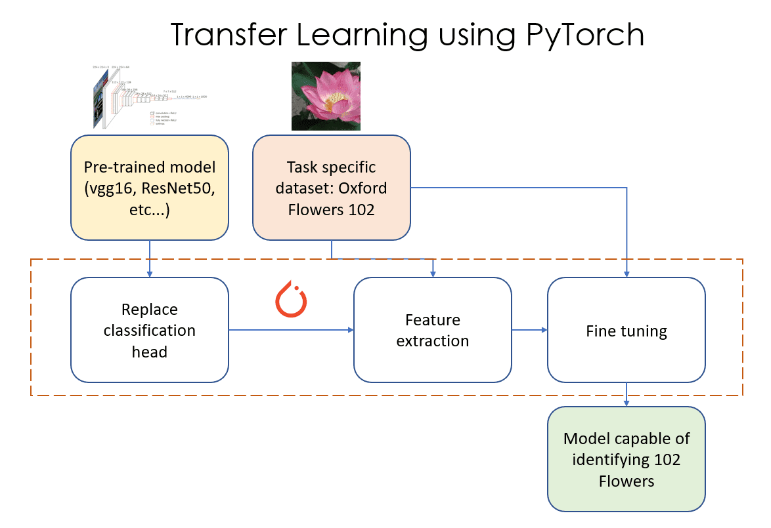

1. **Replace classifier layer**: We would need to replace the last classification head of the pre-trained model with a customised classification head that has the right number of output features.

2. **Feature Extraction**: All the layers of the models, with the exception of newly added classification layer are freezed. The newly added layer is trained.

3. **Fine Tuning**: The subset of the layers in the model are unfreeze (and thus trainable)

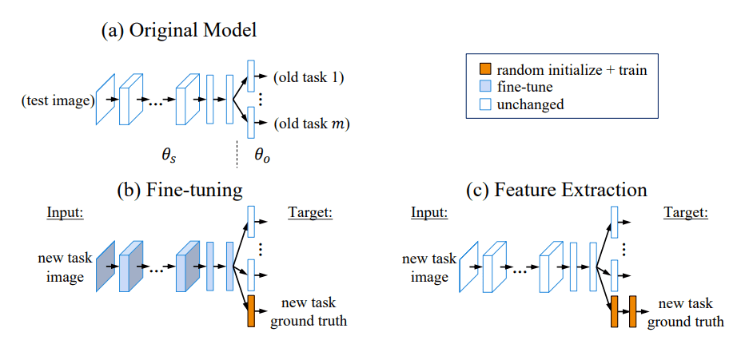

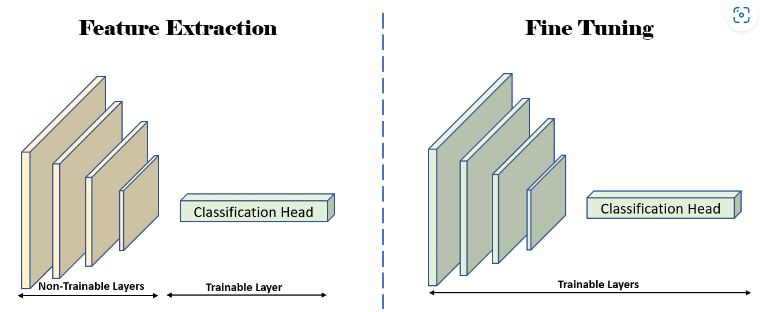

# Libraries

In [1]:
import torch
from torch import nn
import torch.quantization
import numpy as np
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
from torchinfo import summary

from torch.utils.data import ConcatDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data
- We can access several datasets modules from torch vision, this includes all the popular datasets like MNIST, CIFAR10, CIFAR100, ImageNet, etc.
- The dataset files are already labeled and arranged in a compatible manual with Torch vision
  - jpg files - raw image files
  - image label.mat - labels of the image files
- If you are loading datasets manually, it might be worthwhile to investigate available the datasets/loader file structure.

In [3]:
# Loading train and val datasets, to be used as validation datasets
train_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="train",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

val_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="val",
    transform=torchvision.transforms.Compose(
        [torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms()]
    ),
)

# Using the test data as training data, will be applying data augmentation for it.
# Utilize data augmentation techniques on the training data to prevent overfitting
# and allow the model to learn the features so that it can perform predictions on unseen data.
# - Color Jitter
# - Horizontal Flip
# - Rotation
# - Shear
test_data = torchvision.datasets.Flowers102(
    root="data",
    download=True,
    split="test",
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.RandomHorizontalFlip(p=0.5),
            torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
            torchvision.transforms.RandomAffine(degrees=30, shear=20),
            torchvision.models.VGG16_BN_Weights.IMAGENET1K_V1.transforms(),
        ]
    ),
)

flower_test_dataset = ConcatDataset([train_data, val_data])  # as trainval dataset
flower_train_dataset = test_data  # as training datasets

# Number of datasets
print("Number of training datasets: ", len(flower_train_dataset))
print("Number of test datasets: ", len(flower_test_dataset))

Number of training datasets:  6149
Number of test datasets:  2040


If the interest if of best accuracy, it may be worthwhile to use test/val/train split for training. This is not used here as our focus is to showcase training with fine-tuning/transfer setup here.

If you have your own datasets and pre-trained models to use, you might need to modify/tweak the dataloader so that the images and its label are read correctly.

## Image Dataloader setup

In [4]:
image_datasets = {}
image_datasets["train"] = flower_train_dataset
image_datasets["val"] = flower_test_dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=4, shuffle=True, num_workers=4
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}

## Plotting the dataset images

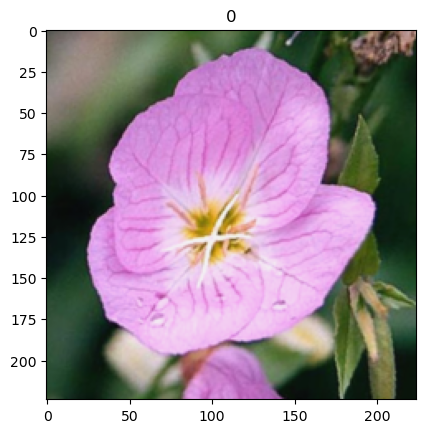

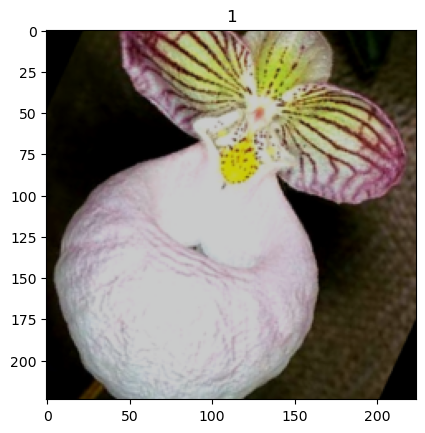

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


imshow(flower_train_dataset[0][0], title=flower_train_dataset._labels[0])
imshow(flower_train_dataset[50][0], title=flower_train_dataset._labels[50])

## Number of labels and label types

Number of labels:  102
Number of images:  6149


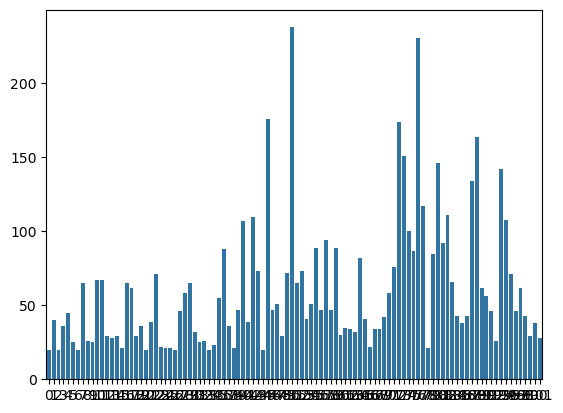

In [6]:
from collections import Counter
import seaborn as sns

sns.barplot(Counter(flower_train_dataset._labels))
print("Number of labels: ", len(Counter(flower_train_dataset._labels)))
print("Number of images: ", len(flower_train_dataset._labels))

# Load the pretrained model
- examples of loading some pre-trained models that is available on torchvision and also depicting their classifier head

In [7]:
# Load pre-trained models, by default all of the models are trained and tested on ImageNet dataset (with 1000 classes)
vgg16 = torchvision.models.vgg16_bn(weights=None)
resnet50 = torchvision.models.resnet50(weights=None)
resnet152 = torchvision.models.resnet152(weights=None)


# we can examine the last layer of the model via the following code
print("vgg16\n", vgg16.classifier)
print("resnet50\n", resnet50.fc)
print("resnet152\n", resnet152.fc)

vgg16
 Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
resnet152
 Linear(in_features=2048, out_features=1000, bias=True)


# Setup: Learning Rates + Layers

## Feature Extraction - Setup

We would require only a learning rate on the classifier head.

- Loading a specific pre-train model
- Modifying the classifier head only

In [8]:
pretrained_model_tl = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)

for param in pretrained_model_tl.parameters():
    param.requires_grad = False

print("Original")
print("\t resnet50\n", pretrained_model_tl.fc)

classifier_layers = [pretrained_model_tl.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_tl.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_tl.fc]

print("Modified")
print("\tresnet50\n", pretrained_model_tl.fc)

# to device
model_ft = pretrained_model_tl.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_tl,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Original
	 resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
Modified
	resnet50
 Linear(in_features=2048, out_features=102, bias=True)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        Partial
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


Note that only the last layer is trainable

In [9]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_tl = optim.SGD(pretrained_model_tl.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)

## Fine Tuning - Setup
Here, we are simple modififying the the final layer to corresponds to our expected output class.


**On Learning Rate**
- Here we are setting it to a small constant. 

There are some that believe in decaying the learning rates as we move up the model towards the initial layers of the model because those initial layers have learnd basic features about the image (edge, patterns). The basic image features are thought to be common for most vision AI tasks.

Thus, the initial layers are trained with low LR to avoid perturbing what they leaned. For layers towards the classification head, we would need higher LR so that the models would learn more task specific.


In [10]:
pretrained_model_ft = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)
classifier_layers = [pretrained_model_ft.fc]
# Parameters of newly constructed modules have requires_grad=True by default
# Replace the final layer with a classifier for 102 classes for the Flowers 102 dataset.
pretrained_model_ft.fc = nn.Linear(in_features=2048, out_features=102, bias=True)
new_layers = [pretrained_model_ft.fc]

# to device
model_ft = pretrained_model_ft.to(device)

# this reliea on torch info package, which would summarize the model and print the model layers (similar to keras)
summary(
    pretrained_model_ft,
    input_size=(32, 3, 224, 224),
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 224, 224]         [32, 102]                 --                        True
├─Conv2d: 1-1                            [32, 3, 224, 224]         [32, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        [32, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 56, 56]          [32, 256, 56, 56]         --                        True
│    │ 

Note that all layers is trainable

In [11]:
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()

# Observethat all parameters are being optimized
# and that it is decay per layers
optimizer_ft = optim.SGD(pretrained_model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train Functions

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        epoch_dict = {
            "train_loss": [],
            "val_loss": [],
            "train_accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
                if phase == "train":
                    epoch_dict["train_loss"].append(epoch_loss)
                    epoch_dict["train_accuracy"].append(epoch_acc)
                else:
                    epoch_dict["val_loss"].append(epoch_loss)
                    epoch_dict["val_accuracy"].append(epoch_acc)

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, epoch_dict

In [13]:
model_tl, epoch_dict_tl = train_model(
    pretrained_model_tl, criterion, optimizer_tl, exp_lr_scheduler, num_epochs=10
)

Epoch 0/24
----------


train Loss: 4.0056 Acc: 0.1992


/home/howt/mambaforge/envs/py310cv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


val Loss: 3.9911 Acc: 0.2005

Epoch 1/24
----------
train Loss: 3.2582 Acc: 0.3897
val Loss: 3.4439 Acc: 0.2873

Epoch 2/24
----------
train Loss: 2.7447 Acc: 0.4858
val Loss: 3.1508 Acc: 0.3578

Epoch 3/24
----------
train Loss: 2.4199 Acc: 0.5464
val Loss: 2.8008 Acc: 0.4549

Epoch 4/24
----------
train Loss: 2.1633 Acc: 0.5978
val Loss: 2.4675 Acc: 0.5074

Epoch 5/24
----------
train Loss: 1.9538 Acc: 0.6471
val Loss: 2.3951 Acc: 0.5015

Epoch 6/24
----------
train Loss: 1.7633 Acc: 0.6852
val Loss: 2.1979 Acc: 0.5574

Epoch 7/24
----------
train Loss: 1.6410 Acc: 0.7084
val Loss: 1.7650 Acc: 0.6525

Epoch 8/24
----------
train Loss: 1.5242 Acc: 0.7395
val Loss: 1.7684 Acc: 0.6593

Epoch 9/24
----------
train Loss: 1.4403 Acc: 0.7535
val Loss: 1.5902 Acc: 0.6838

Epoch 10/24
----------
train Loss: 1.3360 Acc: 0.7715
val Loss: 1.7066 Acc: 0.6843

Epoch 11/24
----------
train Loss: 1.2592 Acc: 0.7922
val Loss: 1.4999 Acc: 0.6975

Epoch 12/24
----------
train Loss: 1.2063 Acc: 0.7940
v

In [14]:
model_ft, epoch_dict_ft = train_model(
    pretrained_model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10
)

Epoch 0/9
----------
train Loss: 4.6253 Acc: 0.0107
val Loss: 4.6346 Acc: 0.0039

Epoch 1/9
----------
train Loss: 4.6223 Acc: 0.0115
val Loss: 4.6306 Acc: 0.0078

Epoch 2/9
----------
train Loss: 4.6201 Acc: 0.0137
val Loss: 4.6301 Acc: 0.0103

Epoch 3/9
----------
train Loss: 4.6190 Acc: 0.0132
val Loss: 4.6299 Acc: 0.0078

Epoch 4/9
----------
train Loss: 4.6168 Acc: 0.0106
val Loss: 4.6296 Acc: 0.0083

Epoch 5/9
----------
train Loss: 4.6169 Acc: 0.0109
val Loss: 4.6305 Acc: 0.0059

Epoch 6/9
----------
train Loss: 4.6185 Acc: 0.0120
val Loss: 4.6295 Acc: 0.0078

Epoch 7/9
----------
train Loss: 4.6161 Acc: 0.0120
val Loss: 4.6304 Acc: 0.0103

Epoch 8/9
----------
train Loss: 4.6167 Acc: 0.0112
val Loss: 4.6288 Acc: 0.0093

Epoch 9/9
----------
train Loss: 4.6163 Acc: 0.0106
val Loss: 4.6300 Acc: 0.0078

Training complete in 12m 4s
Best val Acc: 0.010294


In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                # ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

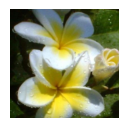

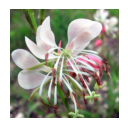

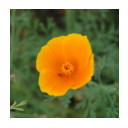

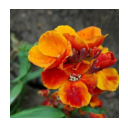

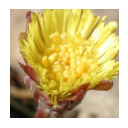

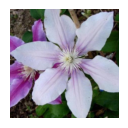

In [16]:
visualize_model(model_ft)

# Results
1. With feature extraction step alone, almost all the networks have an accuracy between 91% and 94%
2. Almost all networks do really well, achieving an accuracy of 96+% after the fine-tuning step. This shows that the fine tuning step really helps during transfer learning.

In [21]:
np.array(epoch_dict_tl['train_accuracy'])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [17]:
epoch_dict_ft

{'train_loss': [4.6253158923260935,
  4.622336161584462,
  4.6201210496560945,
  4.619028925372248,
  4.616826295426152,
  4.616860224068853,
  4.618529809938444,
  4.616137880681103,
  4.6166764551846065,
  4.616329657855044],
 'val_loss': [4.634566936305925,
  4.63055789049934,
  4.630067059573006,
  4.629886492560892,
  4.6295539117326925,
  4.630491801804188,
  4.6294817410263365,
  4.630379108354157,
  4.628778687645407,
  4.630024736067828],
 'train_accuracy': [tensor(0.0107, device='cuda:0', dtype=torch.float64),
  tensor(0.0115, device='cuda:0', dtype=torch.float64),
  tensor(0.0137, device='cuda:0', dtype=torch.float64),
  tensor(0.0132, device='cuda:0', dtype=torch.float64),
  tensor(0.0106, device='cuda:0', dtype=torch.float64),
  tensor(0.0109, device='cuda:0', dtype=torch.float64),
  tensor(0.0120, device='cuda:0', dtype=torch.float64),
  tensor(0.0120, device='cuda:0', dtype=torch.float64),
  tensor(0.0112, device='cuda:0', dtype=torch.float64),
  tensor(0.0106, device='c

# Exercise
1. Can you modified the code to use VGG16 model instead of ResNet50 for Tf and fine-tuning
2. Any siginificant differences?

# References
1. https://www.kdnuggets.com/2023/06/practical-guide-transfer-learning-pytorch.html
2. https://github.com/dhruvbird/ml-notebooks/blob/main/Flowers-102-transfer-learning/flowers102-classification-using-pre-trained-models.ipynb
3. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet